# Part 3: Horse Race Prediction
## Classification Modelling
- In this section, we want to classify if a horse can win the race, and which three horses will be ranked in the top 3.

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import joblib
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [100]:
# Read the train and test files
df_train = pd.read_csv('./data/df_train.csv', index_col=0)
df_test = pd.read_csv('./data/df_test.csv', index_col=0)

In [101]:
# View the shape of the train and test files
print(df_train.shape)
print(df_test.shape)

(23500, 26)
(5864, 26)


In [102]:
# View the first 2 rows of the train file
df_train.head(2)

,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
finishing_position,,,,,,,,,,,,,,,,,,,,,
1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133,1032,1,-,1.0,...,NaN,2014-001,1,1.0,1400,1,1,1,6.052910,7.381862
2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133,1075,13,2,8.0,...,NaN,2014-001,2,2.0,1400,0,1,1,5.825153,6.611465


In [103]:
# View the first 2 rows of the test files
df_test.head(2)

,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
finishing_position,,,,,,,,,,,,,,,,,,,,,
1,5.0,POWERMAX,A009,N Callan,R Gibson,126,1124,9,-,2.0,...,NaN,2016-328,1/4/3/3,2.7500,1200,1,1,1,6.438751,6.715420
2,2.0,BUDDY BUNDY,T157,K K Chiong,D Cruz,127,1193,8,SH,1.0,...,NaN,2016-328,2/11/5/2/6/9,6.8125,1200,0,1,1,6.499033,7.381862


In [104]:
# Keep the features we want to train our model on
X_train = df_train[['actual_weight', 'declared_horse_weight',
                    'draw', #'win_odds', 
                    'jockey_ave_rank',
                    'trainer_ave_rank', 'recent_ave_rank', 'race_distance']]

y_train = df_train[['HorseWin', 'HorseRankTop3', 'HorseRankTop50Percent']]

# Keep the features we want to train our model on
X_test = df_test[['actual_weight', 'declared_horse_weight',
                   'draw', #'win_odds',
                   'jockey_ave_rank',
                    'trainer_ave_rank', 'recent_ave_rank', 'race_distance']]
                    
y_test = df_test[['HorseWin', 'HorseRankTop3', 'HorseRankTop50Percent']]

In [105]:
# View the shape of the train and test files
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23500, 7)
(23500, 3)
(5864, 7)
(5864, 3)


In [106]:
# Check the mean of the target variable
y_train.mean()

HorseWin                 0.080128
HorseRankTop3            0.239787
HorseRankTop50Percent    0.499489
dtype: float64

We can see that there is data imbalance for the HorseWin and HorseRankTop3 variables, so we need to account for these later when modelling.

In [107]:
# Specify kfold cross validation
kfold = KFold(n_splits=5)

### Define functions to run and evaluate models

In [108]:
# Create an empty dataframe to store the results
df_results = pd.DataFrame(columns=['Model', 'Prediction', 'CV-F1', 'F1 Score', 'AUC', 'Recall', 'Precision'])

In [109]:
# Define a function to run the model
def run_model(model, X_train, y_train, X_test, y_test, kfold):

    # Create a dataframe to store the predictions
    df_pred = pd.DataFrame()
    df_pred['RaceID'] = df_test['race_id']
    df_pred['HorseID'] = df_test['horse_id']

    # Store model name
    model_name = str(model).split('(')[0]

    for column in ['HorseWin', 'HorseRankTop3']:

        # Print the column name
        print(f"Results for model {model_name} and target variable {column}:")
        
        # Fit the model
        model.fit(X_train, y_train[column].to_numpy())
        
        # Calculate the cross validation score
        cv_score = cross_val_score(model, X_train, y_train[column].to_numpy(), cv=kfold, scoring='f1_weighted').mean()
        cv_score = round(cv_score, 3)
        
        # Make predictions
        y_pred = model.predict(X_test)

        # Store the predictions in the dataframe
        df_pred[column] = y_pred
        
        # Calculate the f1 score
        f1 = f1_score(y_test[column].to_numpy(), y_pred, average='weighted')
        f1 = round(f1, 3)
        
        # Calculate PR AUC
        pr_auc = average_precision_score(y_test[column].to_numpy(), y_pred, average='weighted')
        pr_auc = round(pr_auc, 3)

        # Calculate Recall
        tn, fp, fn, tp = confusion_matrix(y_test[column].to_numpy(), y_pred).ravel()
        recall = tp / (tp + fn)
        recall = round(recall, 3)

        # Calculate Precision
        precision = tp / (tp + fp)
        precision = round(precision, 3)

        # Append the results to the dataframe
        df_results.loc[len(df_results)] = [model_name, column, cv_score, f1, pr_auc, recall, precision]

        # Print the results
        print('Cross Validation Score (F1-weighted): ', cv_score)
        print('F1 Score: ', f1)
        print('PR AUC (Avg Precision): ', pr_auc)
        print('Recall: ', recall)
        print('Precision: ', precision)

        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, column)

        # Plot precision recall curve
        plot_pr_auc(X_test, y_test, model, column)

    return df_pred

In [110]:
# Define plot confusion matrix function
def plot_confusion_matrix(y_test, y_pred, column):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test[column].to_numpy(), y_pred)
    cm = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for ' + column)
    plt.show()

In [111]:
# Define plot PR AUC function
def plot_pr_auc(X_test, y_test, model, column):
    # Get the probabilities of the predictions
    win_prob = model.predict_proba(X_test)[:, 1]

    # Get the precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test[column], win_prob)

    # Calculate proportion of positive class
    proportion_pos_class = y_test[column].mean()
    
    # Print the PR AUC score
    pr_auc = round(auc(recall, precision),3)
    print(f'PR AUC score for {column}:', pr_auc)

    # Plot the PR AUC curve
    plt.figure(figsize = (8, 6))
    plt.plot([0, 1], [proportion_pos_class, proportion_pos_class], linestyle = '--')
    plt.plot(recall, precision, marker = '.')
    plt.title(f'PR AUC Curve for {column}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()    

### Model 1: Logistic Regression

In [112]:
# Initialize the model
lr = LogisticRegression()

In [113]:
# Do hyperparameter tuning
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                'penalty': ['l1', 'l2']}

grid = GridSearchCV(lr, param_grid, cv=kfold, scoring='f1_weighted', verbose=1, n_jobs=-1)

# find the best parameters
grid.fit(X_train, y_train['HorseWin'].to_numpy())

# Print the best parameters
print(grid.best_params_)
print(grid.best_score_)

# Initialize the model using best parameters
lr = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 1, 'penalty': 'l2'}
0.8899488506949318


Results for model LogisticRegression and target variable HorseWin:
Cross Validation Score (F1-weighted):  0.89
F1 Score:  0.888
PR AUC (Avg Precision):  0.115
Recall:  0.05
Precision:  0.75


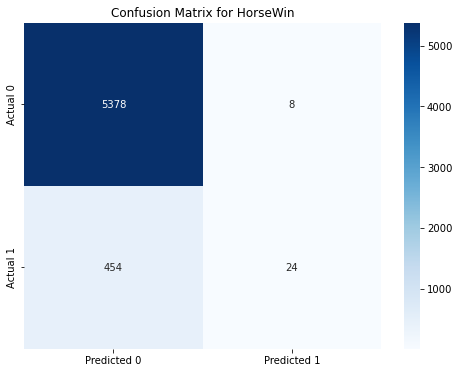

PR AUC score for HorseWin: 0.269


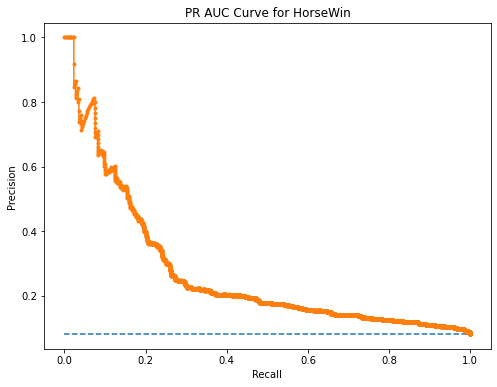

Results for model LogisticRegression and target variable HorseRankTop3:
Cross Validation Score (F1-weighted):  0.769
F1 Score:  0.739
PR AUC (Avg Precision):  0.334
Recall:  0.238
Precision:  0.62


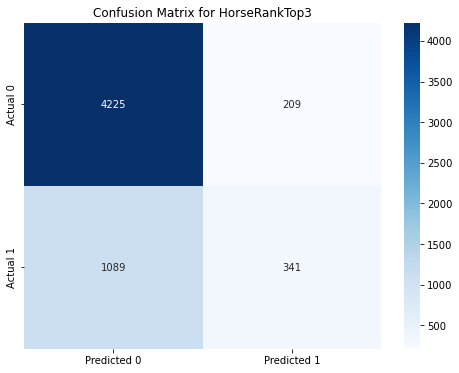

PR AUC score for HorseRankTop3: 0.51


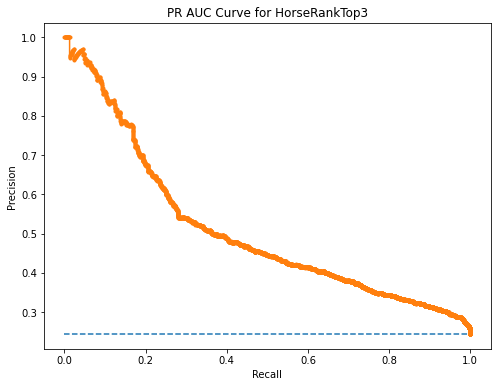

In [114]:
# Run Logistics Regression model
lr_pred = run_model(lr, X_train, y_train, X_test, y_test, kfold)

In [115]:
# Print the results
df_results

,Model,Prediction,CV-F1,F1 Score,AUC,Recall,Precision
0,LogisticRegression,HorseWin,0.890,0.888,0.115,0.050,0.75
1,LogisticRegression,HorseRankTop3,0.769,0.739,0.334,0.238,0.62


### Model 2: Naive Bayes

In [116]:
# Initialize the model
gnb = GaussianNB()

In [117]:
# Do hyperparameter tuning
param_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

grid = GridSearchCV(gnb, param_grid, cv=kfold, scoring='f1_weighted', verbose=1, n_jobs=-1)

# find the best parameters
grid.fit(X_train, y_train['HorseWin'].to_numpy())

# Print the best parameters
print(grid.best_params_)
print(grid.best_score_)

# Initialize the model using best parameters
gnb = grid.best_estimator_

Fitting 5 folds for each of 13 candidates, totalling 65 fits
{'var_smoothing': 1e-06}
0.8917780246896244


Results for model GaussianNB and target variable HorseWin:
Cross Validation Score (F1-weighted):  0.892
F1 Score:  0.893
PR AUC (Avg Precision):  0.127
Recall:  0.146
Precision:  0.395


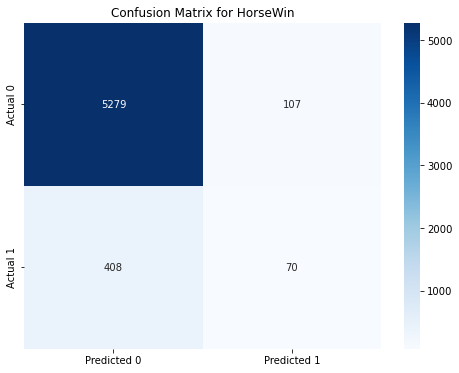

PR AUC score for HorseWin: 0.23


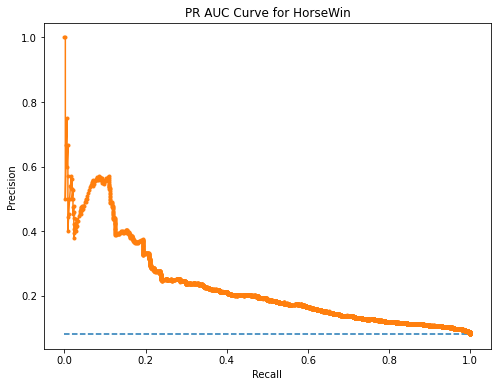

Results for model GaussianNB and target variable HorseRankTop3:
Cross Validation Score (F1-weighted):  0.768
F1 Score:  0.744
PR AUC (Avg Precision):  0.337
Recall:  0.341
Precision:  0.519


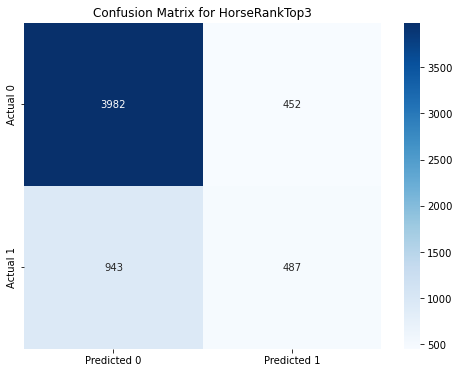

PR AUC score for HorseRankTop3: 0.476


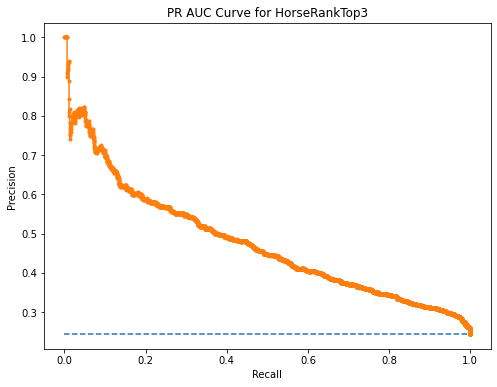

In [118]:
# Run Naive Bayes model
gnb_pred = run_model(gnb, X_train, y_train, X_test, y_test, kfold)

In [119]:
# Print the results
df_results

,Model,Prediction,CV-F1,F1 Score,AUC,Recall,Precision
0,LogisticRegression,HorseWin,0.890,0.888,0.115,0.050,0.750
1,LogisticRegression,HorseRankTop3,0.769,0.739,0.334,0.238,0.620
2,GaussianNB,HorseWin,0.892,0.893,0.127,0.146,0.395
3,GaussianNB,HorseRankTop3,0.768,0.744,0.337,0.341,0.519


### Model 3: Random Forest Classifier

In [120]:
# Initialize the model
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [121]:
# Do hyperparameter tuning
param_grid = {'max_depth': [20, 40],
                'max_features': [5, 10],
                'min_samples_leaf': [1, 2],
                'min_samples_split': [1, 2]}
grid = GridSearchCV(rfc, param_grid, cv=kfold, scoring='f1_weighted', verbose=1, n_jobs=-1)

# find the best parameters
grid.fit(X_train, y_train['HorseWin'].to_numpy())

# Print the best parameters
print(grid.best_params_)
print(grid.best_score_)

# Initialize the model using best parameters
rfc = grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 40, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.898091856165121


Results for model RandomForestClassifier and target variable HorseWin:
Cross Validation Score (F1-weighted):  0.898
F1 Score:  0.894
PR AUC (Avg Precision):  0.131
Recall:  0.09
Precision:  0.632


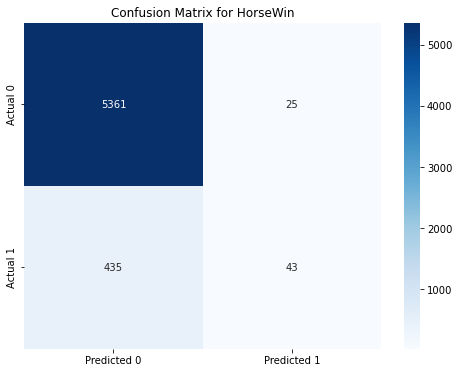

PR AUC score for HorseWin: 0.256


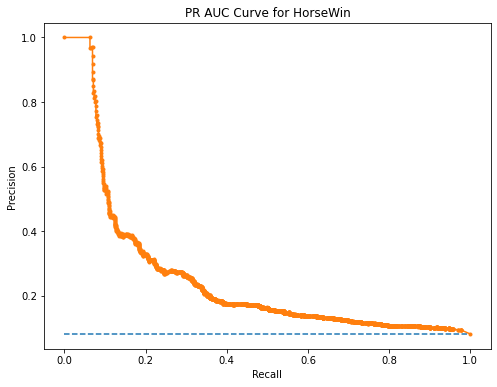

Results for model RandomForestClassifier and target variable HorseRankTop3:
Cross Validation Score (F1-weighted):  0.768
F1 Score:  0.74
PR AUC (Avg Precision):  0.332
Recall:  0.25
Precision:  0.598


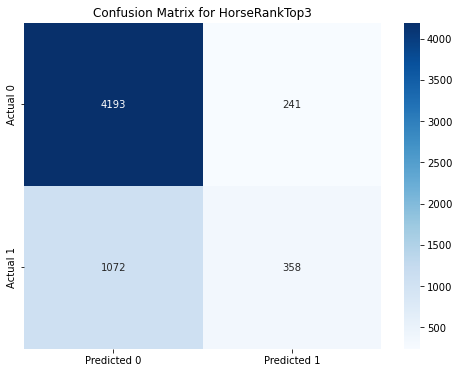

PR AUC score for HorseRankTop3: 0.495


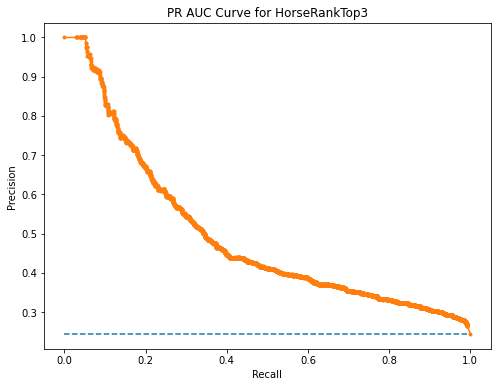

In [122]:
# Run Random Forest model
rfc_pred = run_model(rfc, X_train, y_train, X_test, y_test, kfold)

In [123]:
# Print the results
df_results

,Model,Prediction,CV-F1,F1 Score,AUC,Recall,Precision
0,LogisticRegression,HorseWin,0.890,0.888,0.115,0.050,0.750
1,LogisticRegression,HorseRankTop3,0.769,0.739,0.334,0.238,0.620
2,GaussianNB,HorseWin,0.892,0.893,0.127,0.146,0.395
3,GaussianNB,HorseRankTop3,0.768,0.744,0.337,0.341,0.519
4,RandomForestClassifier,HorseWin,0.898,0.894,0.131,0.090,0.632
5,RandomForestClassifier,HorseRankTop3,0.768,0.740,0.332,0.250,0.598


### Model 4: SMOTE + Random Forest Classifier

In [124]:
# Smote the training data
sm = SMOTE(random_state = 42)
rfc = RandomForestClassifier(max_depth=20, min_samples_leaf=10, random_state = 42)

# Steps for the pipeline
steps = [('smote', sm), ('rfc', rfc)]

# Create the pipeline
smote_rfc = Pipeline(steps = steps)


Results for model Pipeline and target variable HorseWin:
Cross Validation Score (F1-weighted):  0.866
F1 Score:  0.863
PR AUC (Avg Precision):  0.131
Recall:  0.347
Precision:  0.223


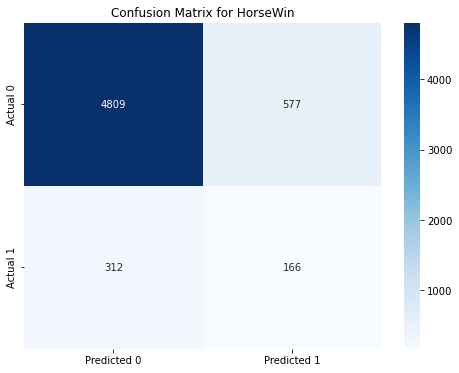

PR AUC score for HorseWin: 0.199


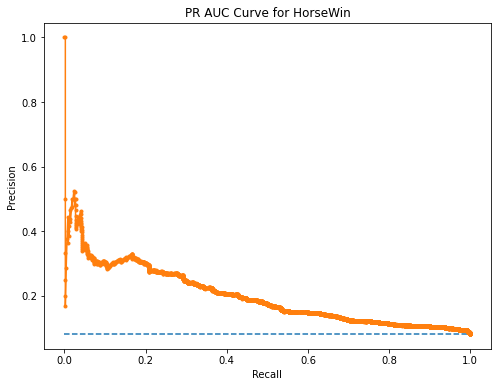

Results for model Pipeline and target variable HorseRankTop3:
Cross Validation Score (F1-weighted):  0.757
F1 Score:  0.722
PR AUC (Avg Precision):  0.339
Recall:  0.517
Precision:  0.428


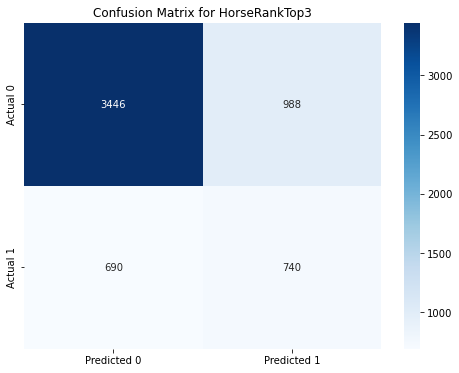

PR AUC score for HorseRankTop3: 0.493


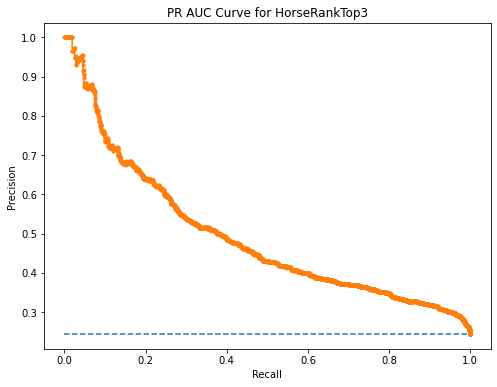

In [125]:
# Run the model
smote_rfc_pred = run_model(smote_rfc, X_train, y_train, X_test, y_test, kfold)

### View the final results of our 4 classification models

In [126]:
# View the results
df_results.sort_values(by='Prediction', ascending=False)

,Model,Prediction,CV-F1,F1 Score,AUC,Recall,Precision
0,LogisticRegression,HorseWin,0.890,0.888,0.115,0.050,0.750
2,GaussianNB,HorseWin,0.892,0.893,0.127,0.146,0.395
4,RandomForestClassifier,HorseWin,0.898,0.894,0.131,0.090,0.632
6,Pipeline,HorseWin,0.866,0.863,0.131,0.347,0.223
1,LogisticRegression,HorseRankTop3,0.769,0.739,0.334,0.238,0.620
3,GaussianNB,HorseRankTop3,0.768,0.744,0.337,0.341,0.519
5,RandomForestClassifier,HorseRankTop3,0.768,0.740,0.332,0.250,0.598
7,Pipeline,HorseRankTop3,0.757,0.722,0.339,0.517,0.428


We will choose the Random Forest Classifer with SMOTE as our deployed model as it has good generalisation between the train and test F1 scores, the highest PR AUC and TPR.

In [127]:
# Save our models to csv
lr_pred.to_csv('./predictions/lr_pred.csv', index=False)
gnb_pred.to_csv('./predictions/gnb_pred.csv', index=False)
rfc_pred.to_csv('./predictions/rfc_pred.csv', index=False)
smote_rfc_pred.to_csv('./predictions/smote_rfc_pred.csv', index=False)

In [128]:
# Save our Pipeline model to a file
joblib.dump(smote_rfc, './model/smote_rfc_model.pkl')

['./model/smote_rfc_model.pkl']

In [129]:
# Save results to csv
df_results.to_csv('./results/class_results.csv', index=False)
